В этом блокноте мы будем доказывать/опровергать гипотезу 

"Свободный график компенсирует низкий уровень зарплаты, особенно среди женщин"

# Необходимые библиотеки

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [80]:
from tqdm import tqdm

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
from scipy.stats import kstest, norm, mannwhitneyu, kruskal, ttest_ind, chisquare, poisson, chi2

In [83]:
import warnings

In [84]:
warnings.filterwarnings(action='ignore')

# Загрузка данных

In [85]:
data = pd.read_csv('cleared_data.csv')
#data = pd.read_csv(r'big_data.csv')
data.head()

,vacancy_id,employer_id,employees_number,creation_date,work_schedule,employment,length_of_employment,compensation_from,compensation_to,accept_teenagers,...,young_male_response_count,invitation_count,female_invitation_count,male_invitation_count,young_invitation_count,young_female_invitation_count,young_male_invitation_count,industry_id_list,correct_salary,length_industry_list
0,78161908,4809555,50,2023-03-17,shift,full,no_experience,22500.0,22500.0,False,...,1,26,26,0,2,2,0,[None],approximately,0
1,79496395,5667513,5,2023-04-19,shift,full,up_to_3_years,24000.0,30000.0,False,...,0,3,3,0,0,0,0,[None],correct,0
2,87102246,1072323,0,2023-09-21,full_day,full,up_to_3_years,50000.0,50000.0,False,...,0,9,7,2,0,0,0,"[7, 8]",approximately,2
3,76367381,1160192,0,2023-01-30,full_day,full,up_to_3_years,55000.0,150000.0,False,...,0,49,39,10,0,0,0,"[5, 13]",correct,2
4,81516485,1025275,38000,2023-06-05,shift,full,no_experience,38500.0,56500.0,False,...,1,13,0,13,1,0,1,"[8, 41]",correct,2


In [86]:
len(data) / 377000 

0.8498620689655172

In [87]:
data['compensation_from'].describe()

count    320398.000000
mean      51555.418336
std       25673.403819
min        3000.000000
25%       35000.000000
50%       45000.000000
75%       60000.000000
max      150000.000000
Name: compensation_from, dtype: float64

In [88]:
data = data[data['compensation_from'] >= 1000]

### изменяем тип creation_date

In [89]:
data['creation_date'] = pd.to_datetime(data['creation_date'])

# Преданализ

In [90]:
data['work_schedule'] = data['work_schedule'].replace({'flexible': 'flexible&remote', 'remote': 'flexible&remote'})
data['work_schedule'] = data['work_schedule'].replace({'flyInFlyOut': 'tight', 'full_day': 'tight', 'shift': 'tight'})

In [91]:
data['share_of_women'] = np.round(data['female_response_count'] / data['response_count'], 3)
data[['work_schedule', 'compensation_from', 'female_response_count', 'male_response_count', 'share_of_women']].head()

,work_schedule,compensation_from,female_response_count,male_response_count,share_of_women
0,tight,22500.0,41,6,0.872
1,tight,24000.0,10,1,0.909
2,tight,50000.0,10,5,0.667
3,tight,55000.0,28,13,0.683
4,tight,38500.0,5,6,0.455


## попробуем доказать, что при установлении графика 'flexible' и снижении зарплаты число откликов не меняется

In [92]:
labels = ['Ниже среднего', 'Выше среднего']
bins = [0, 57000, data['compensation_from'].max()]

data['salary_cat'] = pd.cut(data['compensation_from'], bins=bins, labels=labels)

In [93]:
data.groupby(['work_schedule', 'salary_cat']).agg({'response_count': lambda x: x.mean(), 'share_of_women': lambda x: x.mean()})

response_count  share_of_women
work_schedule   salary_cat                                   
flexible&remote Ниже среднего       18.690580        0.662653
                Выше среднего       16.643245        0.368396
tight           Ниже среднего       14.572775        0.579723
                Выше среднего       13.650468        0.264816

In [94]:
data.groupby(['work_schedule', 'salary_cat',]).agg(
                        no_experience_percent = ('length_of_employment', lambda x: round(x.value_counts(normalize=True).get('no_experience', 0), 3) * 100),
                        up_to_3_years_percent = ('length_of_employment', lambda x: round(x.value_counts(normalize=True).get('up_to_3_years', 0), 3) * 100),
                        up_to_6_years_percent = ('length_of_employment', lambda x: round(x.value_counts(normalize=True).get('up_to_6_years', 0), 3) * 100),
                        above_6_years_percent = ('length_of_employment', lambda x: round(x.value_counts(normalize=True).get('above_6_years', 0), 3) * 100),
                                                    )

no_experience_percent  up_to_3_years_percent  \
work_schedule   salary_cat                                                    
flexible&remote Ниже среднего                   78.4                   20.1   
                Выше среднего                   74.4                   23.1   
tight           Ниже среднего                   56.4                   40.0   
                Выше среднего                   31.5                   55.6   

                               up_to_6_years_percent  above_6_years_percent  
work_schedule   salary_cat                                                   
flexible&remote Ниже среднего                    1.4                    0.1  
                Выше среднего                    2.4                    0.2  
tight           Ниже среднего                    3.3                    0.2  
                Выше среднего                   12.3                    0.7

# Доказываем статистическую значимость

In [95]:
mu, sigma = data['female_response_count'].mean(), data['female_response_count'].std()

kstest(data['female_response_count'], norm(loc=mu, scale=sigma).cdf)

KstestResult(statistic=0.2594990165415642, pvalue=0.0, statistic_location=0, statistic_sign=-1)

In [96]:
mu, sigma = data['response_count'].mean(), data['response_count'].std()

kstest(data['response_count'], norm(loc=mu, scale=sigma).cdf)

KstestResult(statistic=0.20516450281264376, pvalue=0.0, statistic_location=1, statistic_sign=-1)

распределения обоих признаков далеко от нормального

In [97]:
group_1 = data[(data['work_schedule'] == 'flexible&remote') & (data['salary_cat'] == 'Ниже среднего')]
group_2 = data[(data['work_schedule'] != 'flexible&remote') & (data['salary_cat'] == 'Ниже среднего')]
group_3 = data[(data['work_schedule'] == 'flexible&remote') & (data['salary_cat'] == 'Ниже среднего')]
group_4 = data[(data['work_schedule'] == 'flexible&remote') & (data['salary_cat'] != 'Ниже среднего')]
group_5 = data[(data['work_schedule'] != 'flexible&remote') & (data['salary_cat'] != 'Ниже среднего')]
group_1['type'] = 'Свободный график и низкая зп'
group_2['type'] = 'Полная занятость и низкая зп'
group_3['type'] = 'Свободный график и низкая зп'
group_4['type'] = 'Свободный график и высокая зп'
group_5['type'] = 'Полная занятость и высокая зп'

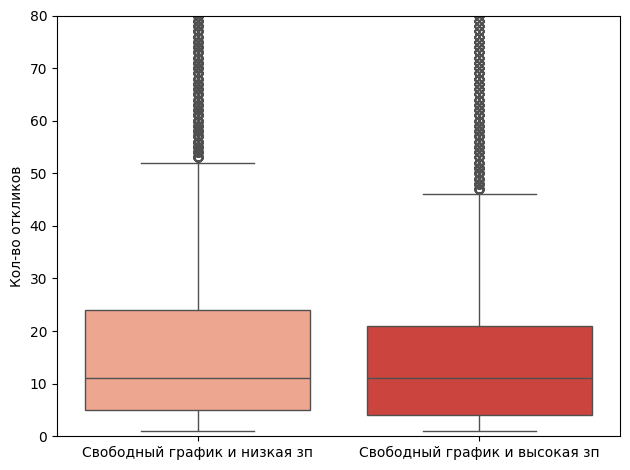

In [98]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Объединение данных и переименование столбцов
# combined_data = pd.concat([group_1, group_2]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'})


# Построение графиков
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([group_1, group_4]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds')


# Установка ограничений по оси Y для всех графиков

plt.ylim(0, 80)  # Установка ограничений по оси Y



# Заголовок и подписи

plt.xlabel('')  # Подпись для оси X
plt.ylabel('Кол-во откликов')  # Подпись для оси Y

plt.tight_layout()
plt.show()

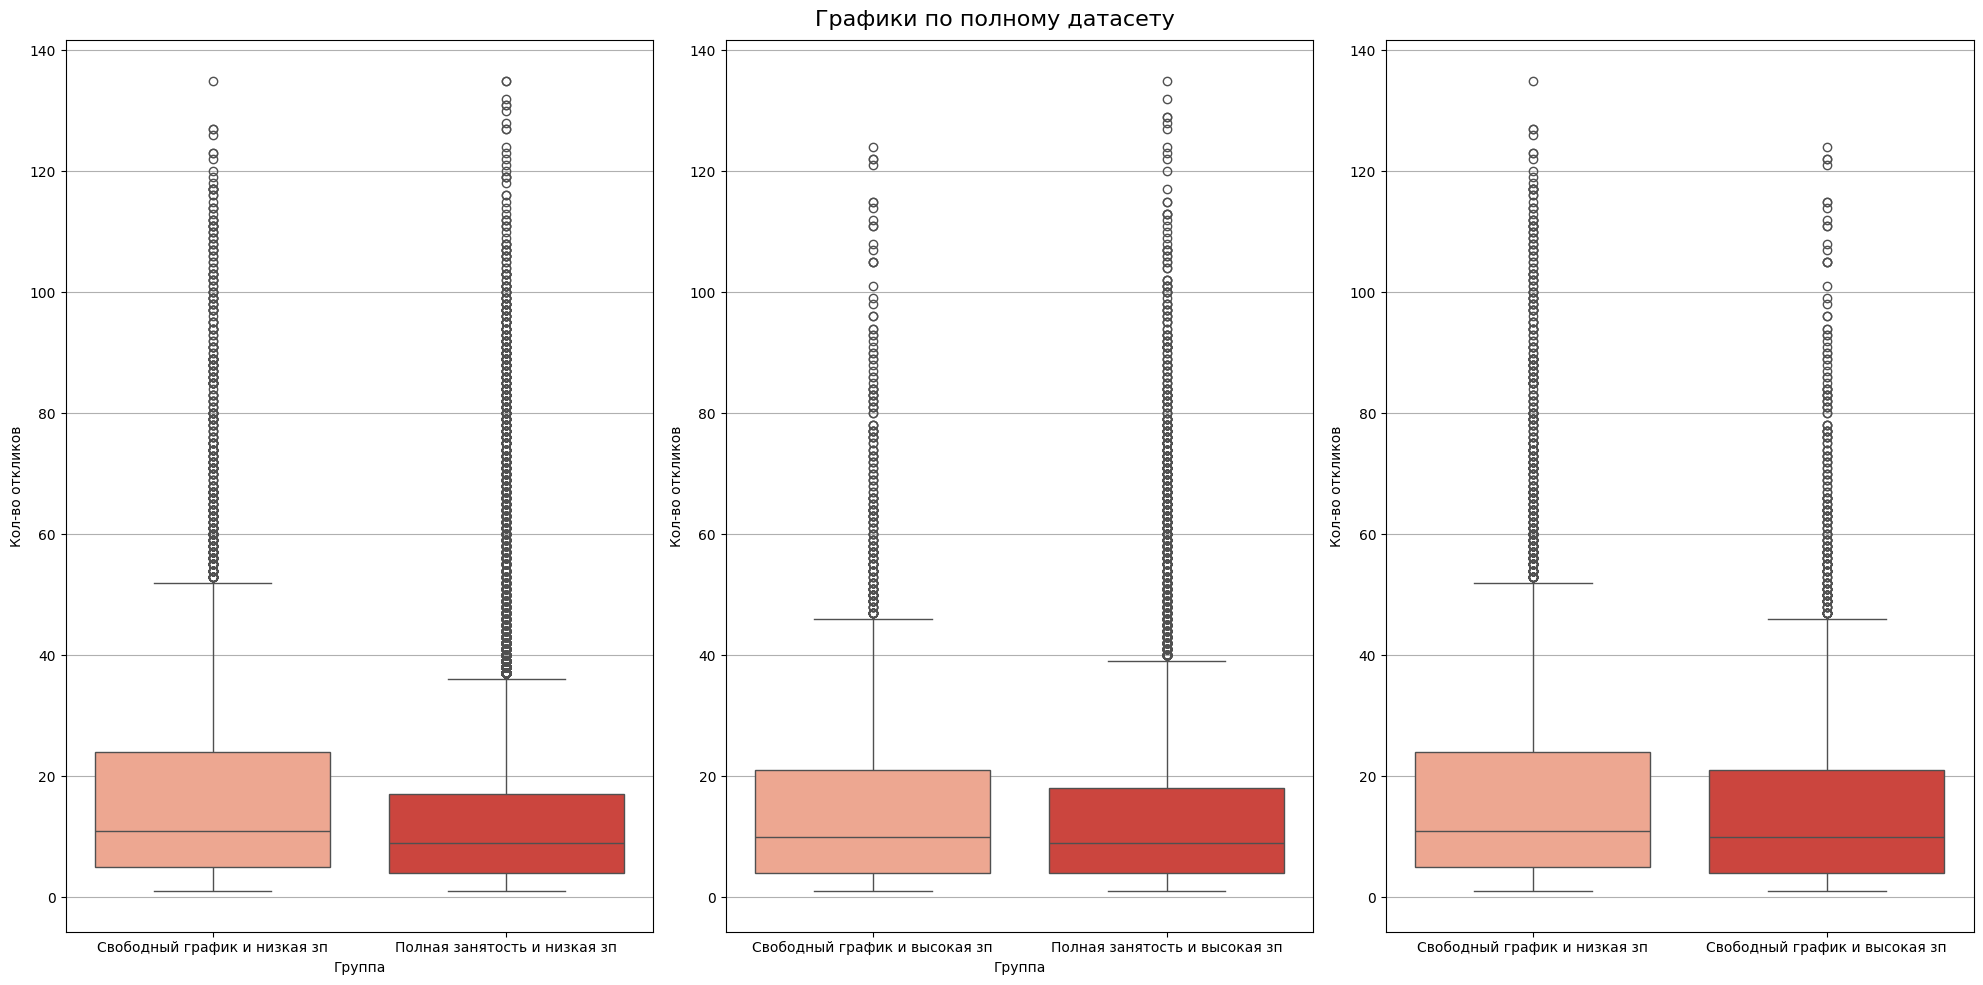

In [150]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Объединение данных и переименование столбцов
# combined_data = pd.concat([group_1, group_2]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'})

fig, axis = plt.subplots(1, 3, figsize=(20, 10))

# Построение графиков
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([group_1, group_2]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[0])
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([group_4, group_5]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[1])
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([group_3, group_4]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[2])

# Установка ограничений по оси Y для всех графиков
for ax in axis:
    # ax.set_ylim(0, 80)  # Установка ограничений по оси Y
    ax.grid(axis='y')


# Заголовок и подписи
fig.suptitle('Графики по полному датасету', fontsize=16)
plt.xlabel('')  # Подпись для оси X
plt.ylabel('Кол-во откликов')  # Подпись для оси Y

plt.tight_layout()
plt.show()

In [100]:
len(group_1), len(group_2), len(group_3), len(group_4)

(29161, 198310, 29161, 13435)

In [101]:
group_1['response_count'].mean(), group_2['response_count'].mean()

(18.690579884091765, 14.572774948313247)

In [102]:
test = ttest_ind(group_1['response_count'], group_2['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 38.56474408400285, p-value 0.0


In [103]:
group_4['response_count'].mean(), group_5['response_count'].mean()

(16.64324525493115, 13.650467971619786)

In [104]:
test = ttest_ind(group_4['response_count'], group_5['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 20.15223789120778, p-value 4.012276776783214e-90


In [105]:
group_3['response_count'].mean(), group_4['response_count'].mean()

(18.690579884091765, 16.64324525493115)

In [106]:
test = ttest_ind(group_3['response_count'], group_4['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 9.764409618849918, p-value 1.6898681197928248e-22


In [107]:
group_2['response_count'].mean(), group_5['response_count'].mean()

(14.572774948313247, 13.650467971619786)

In [108]:
test = ttest_ind(group_2['response_count'], group_5['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 13.622361110242993, p-value 3.042561102022763e-42


In [109]:
samp, _ = train_test_split(data, test_size=0.5, stratify=data[['work_schedule']], random_state=42)

In [110]:
samp['work_schedule'].value_counts()['flexible&remote'] / len(samp), data['work_schedule'].value_counts()['flexible&remote'] / len(data)

(0.13294714698593624, 0.13294714698593624)

In [111]:
group_1 = samp[(samp['work_schedule'] == 'flexible&remote') & (samp['salary_cat'] == 'Ниже среднего')]
group_2 = samp[(samp['work_schedule'] != 'flexible&remote') & (samp['salary_cat'] == 'Ниже среднего')]
group_3 = samp[(samp['work_schedule'] == 'flexible&remote') & (samp['salary_cat'] == 'Ниже среднего')]
group_4 = samp[(samp['work_schedule'] == 'flexible&remote') & (samp['salary_cat'] != 'Ниже среднего')]
group_5 = samp[(samp['work_schedule'] != 'flexible&remote') & (samp['salary_cat'] != 'Ниже среднего')]
group_1['type'] = 'Свободный график и низкая зп'
group_2['type'] = 'Полная занятость и низкая зп'
group_3['type'] = 'Свободный график и низкая зп'
group_4['type'] = 'Свободный график и высокая зп'
group_5['type'] = 'Полная занятость и высокая зп'

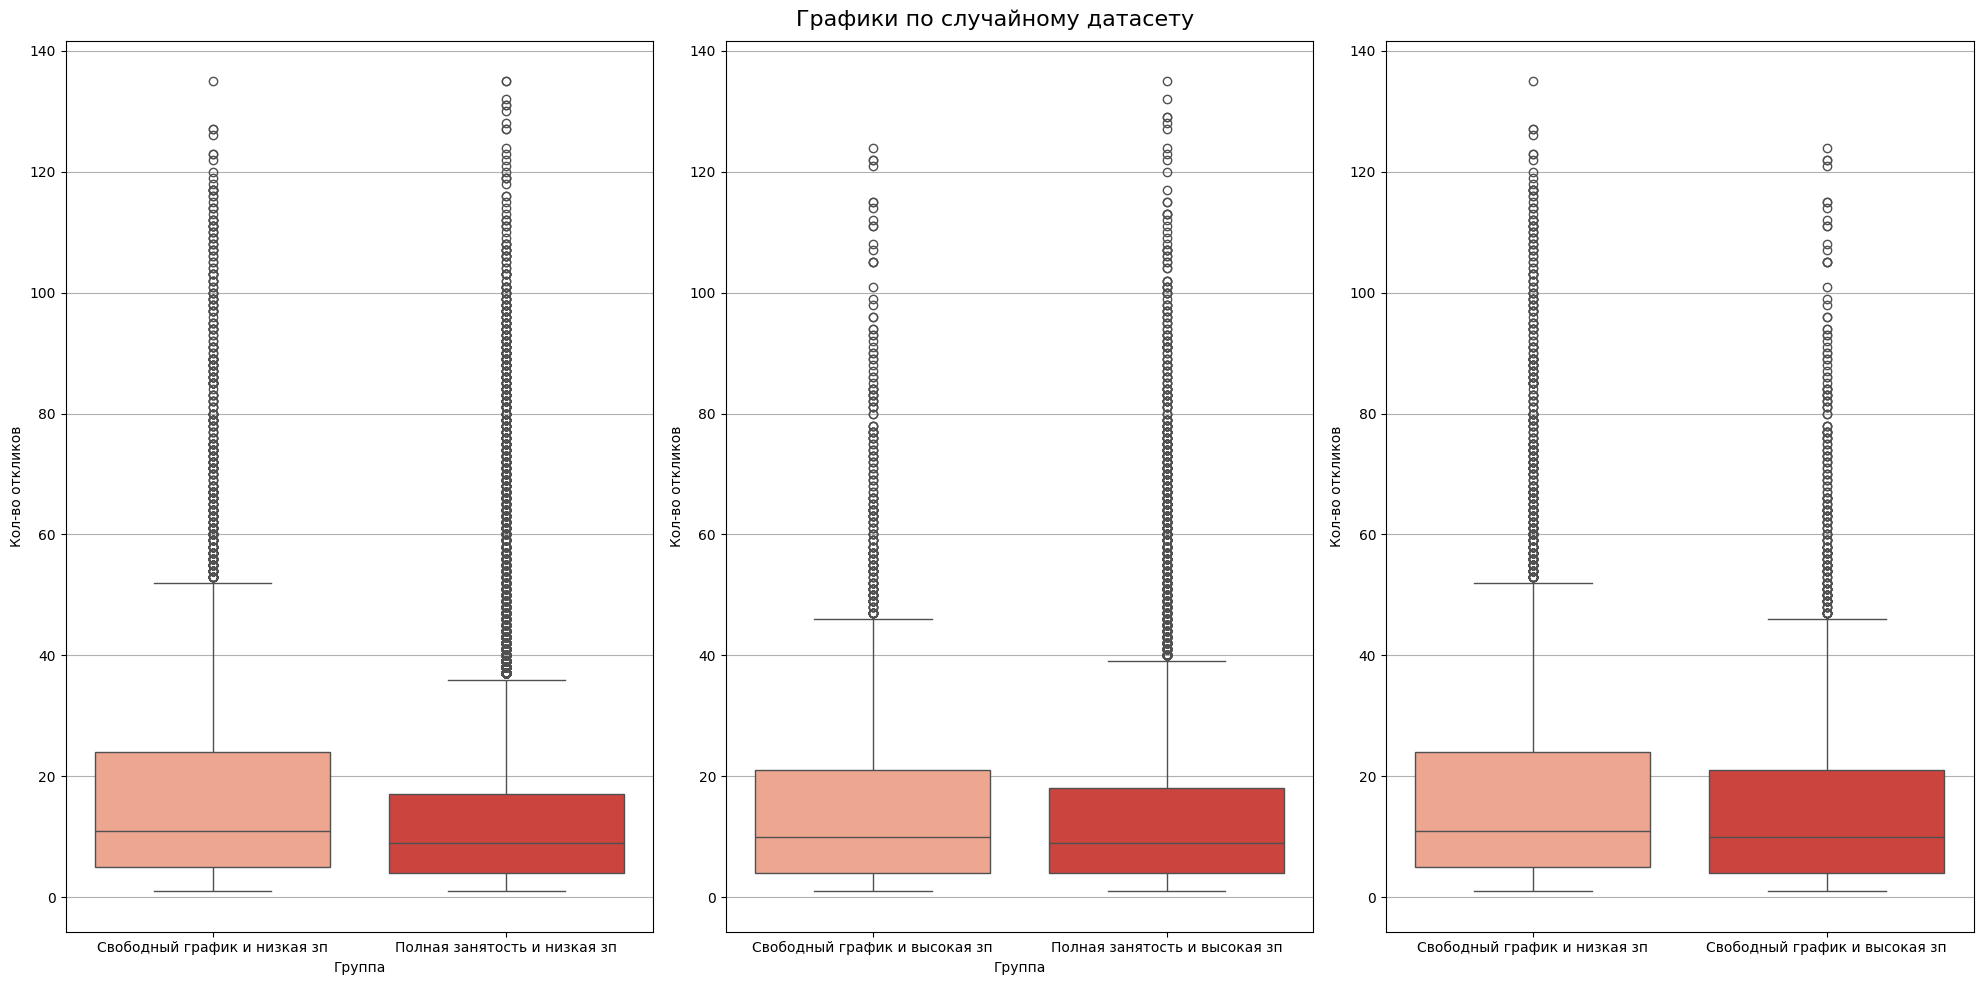

In [149]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Объединение данных и переименование столбцов
# combined_data = pd.concat([group_1, group_2]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'})

fig, axis = plt.subplots(1, 3, figsize=(20, 10))

# Построение графиков
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([group_1, group_2]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[0])
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([group_4, group_5]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[1])
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([group_3, group_4]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[2])

# Установка ограничений по оси Y для всех графиков
for ax in axis:
    # ax.set_ylim(0, 80)  # Установка ограничений по оси Y
    ax.grid(axis='y')


# Заголовок и подписи
fig.suptitle('Графики по случайному датасету', fontsize=16)
plt.xlabel('')  # Подпись для оси X
plt.ylabel('Кол-во откликов')  # Подпись для оси Y

plt.tight_layout()
plt.show()

In [113]:
group_1['response_count'].mean(), group_2['response_count'].mean()

(18.65207198510653, 14.57686250757117)

In [114]:
test = ttest_ind(group_1['response_count'], group_2['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 26.94069910095705, p-value 2.333945829832477e-159


In [115]:
group_4['response_count'].mean(), group_5['response_count'].mean()

(16.757321559970567, 13.618232474084486)

In [116]:
test = ttest_ind(group_4['response_count'], group_5['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 15.095704960113222, p-value 2.28658559469361e-51


In [117]:
group_3['response_count'].mean(), group_4['response_count'].mean()

(18.65207198510653, 16.757321559970567)

In [118]:
test = ttest_ind(group_3['response_count'], group_4['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 6.409091579314832, p-value 1.4945641389436547e-10


In [119]:
group_2['response_count'].mean(), group_5['response_count'].mean()

(14.57686250757117, 13.618232474084486)

In [120]:
test = ttest_ind(group_2['response_count'], group_5['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 10.041920835712931, p-value 1.0159082167408174e-23


In [121]:
sverd = data[data['region_name'] == 'Свердловская область']

In [122]:
group_1 = sverd[(sverd['work_schedule'] == 'flexible&remote') & (sverd['salary_cat'] == 'Ниже среднего')]
group_2 = sverd[(sverd['work_schedule'] != 'flexible&remote') & (sverd['salary_cat'] == 'Ниже среднего')]

group_3 = sverd[(sverd['work_schedule'] == 'flexible&remote') & (sverd['salary_cat'] == 'Ниже среднего')]
group_4 = sverd[(sverd['work_schedule'] == 'flexible&remote') & (sverd['salary_cat'] != 'Ниже среднего')]
group_5 = sverd[(sverd['work_schedule'] != 'flexible&remote') & (sverd['salary_cat'] != 'Ниже среднего')]
group_1['type'] = 'Свободный график и низкая зп'
group_2['type'] = 'Полная занятость и низкая зп'
group_3['type'] = 'Свободный график и низкая зп'
group_4['type'] = 'Свободный график и высокая зп'
group_5['type'] = 'Полная занятость и высокая зп'

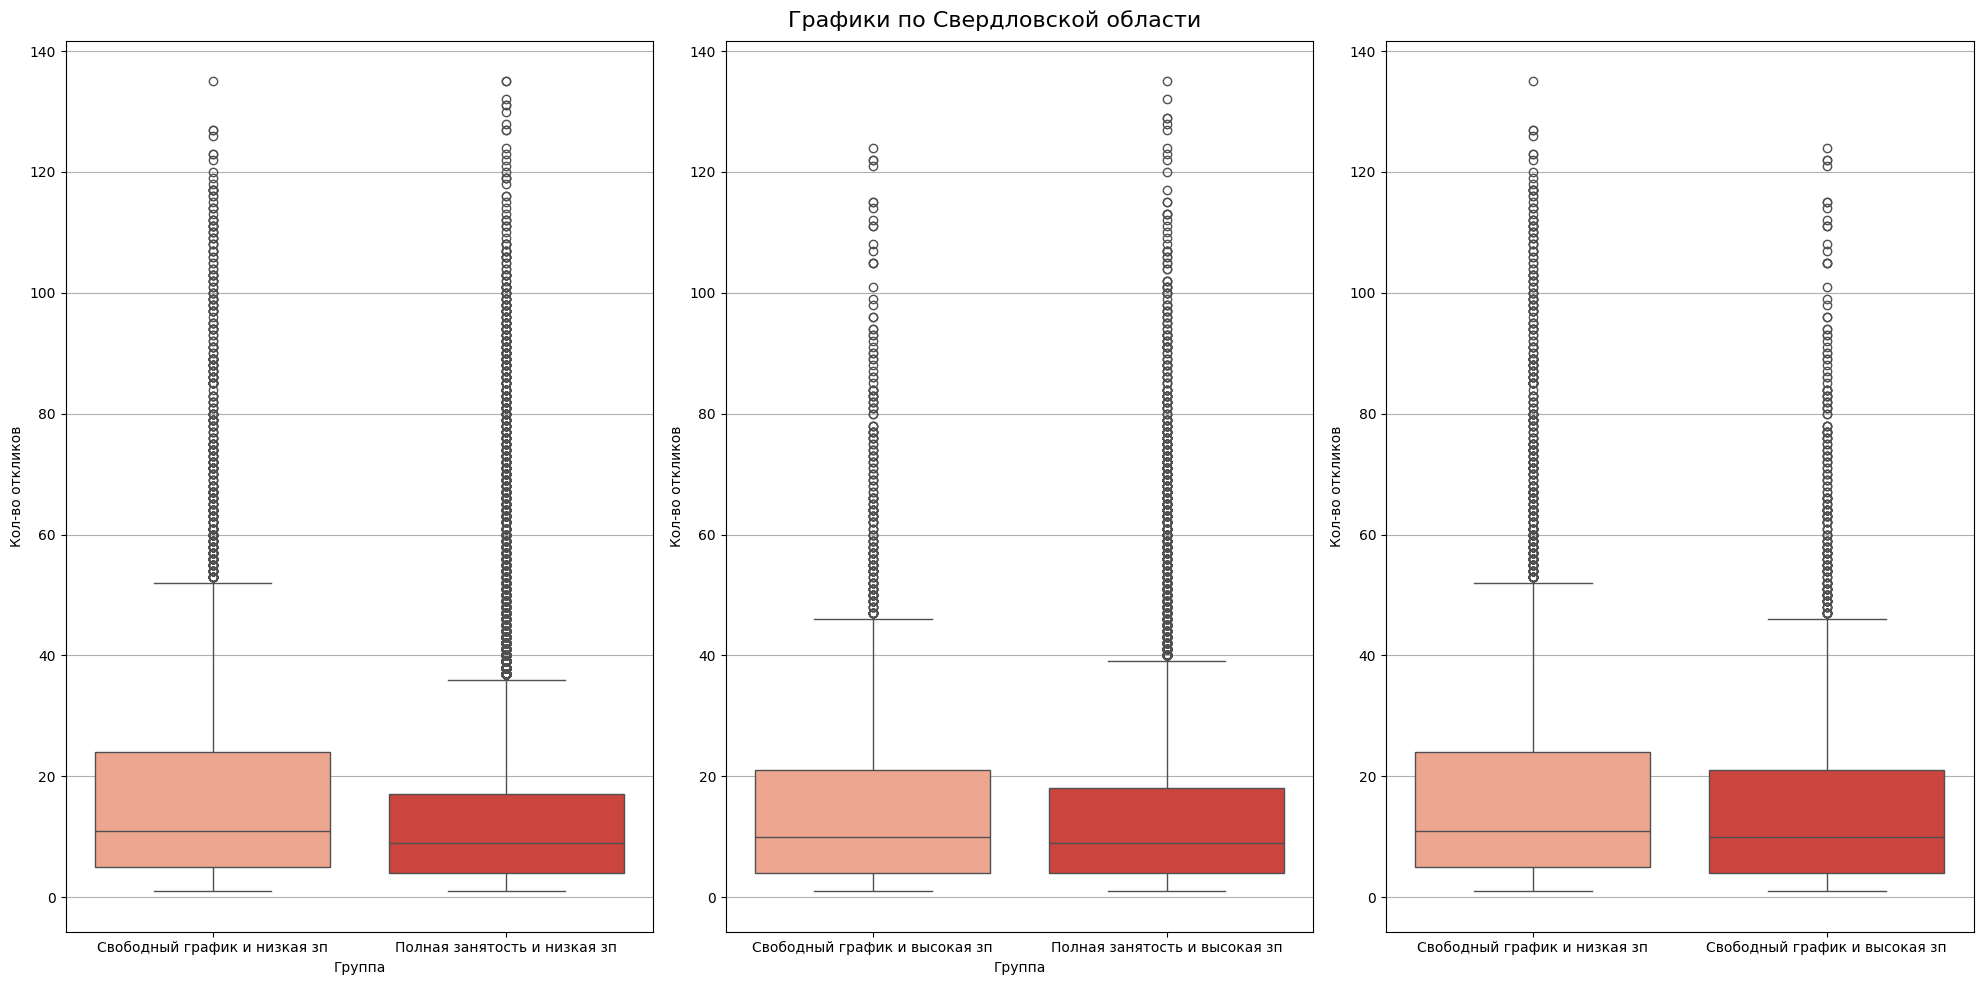

In [148]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Объединение данных и переименование столбцов
# combined_data = pd.concat([group_1, group_2]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'})

fig, axis = plt.subplots(1, 3, figsize=(20, 10))

# Построение графиков
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([group_1, group_2]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[0])
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([group_4, group_5]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[1])
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([group_3, group_4]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[2])

# Установка ограничений по оси Y для всех графиков
for ax in axis:
    # ax.set_ylim(0, 80)  # Установка ограничений по оси Y
    ax.grid(axis='y')


# Заголовок и подписи
fig.suptitle('Графики по Свердловской области', fontsize=16)
plt.xlabel('')  # Подпись для оси X
plt.ylabel('Кол-во откликов')  # Подпись для оси Y

plt.tight_layout()
plt.show()

In [124]:
group_1['response_count'].mean(), group_2['response_count'].mean()

(18.829236977256052, 13.803616431451612)

In [125]:
test = ttest_ind(group_1['response_count'], group_2['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 20.55179251978107, p-value 2.45223406113275e-93


In [126]:
group_4['response_count'].mean(), group_5['response_count'].mean()

(16.423597025016903, 14.43593987036271)

In [127]:
test = ttest_ind(group_4['response_count'], group_5['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 5.905409385132334, p-value 3.582970594704165e-09


In [128]:
group_3['response_count'].mean(), group_4['response_count'].mean()

(18.829236977256052, 16.423597025016903)

In [129]:
test = ttest_ind(group_3['response_count'], group_4['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 5.151200379906261, p-value 2.646992416066478e-07


In [130]:
group_2['response_count'].mean(), group_5['response_count'].mean()

(13.803616431451612, 14.43593987036271)

In [131]:
test = ttest_ind(group_2['response_count'], group_5['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric -3.9677599093838234, p-value 7.266073044224137e-05


In [132]:
len(group_1), len(group_2), len(group_3), len(group_4), len(group_5), 

(5452, 31744, 5452, 2958, 14502)

# Альт механизм

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9822
Date:                Mon, 16 Dec 2024   Prob (F-statistic):              0.324
Time:                        15:15:35   Log-Likelihood:                -35.926
No. Observations:                 100   AIC:                             75.85
Df Residuals:                      98   BIC:                             81.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1798      0.069     -2.588      0.0

<Axes: >

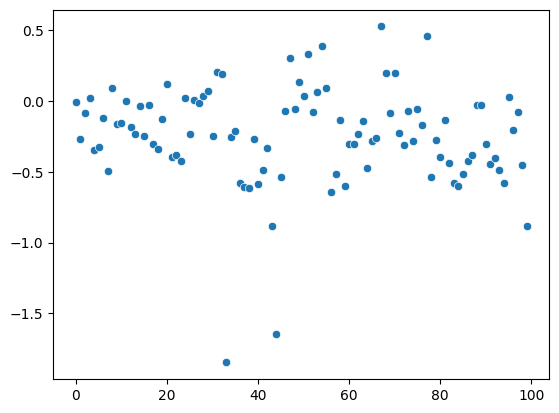

In [133]:
import statsmodels.api as sm


def wrapper(count_bucket):
    ft = len(data) // count_bucket
    lst = [data.iloc[i: i + ft] for i in range(0, len(data), ft)][:-1]
    for t in lst:
        t1 = t[(t['work_schedule'] != 'tight') & (t['length_of_employment'] == 'no_experience')]['response_count']
        t2 = t[(t['work_schedule'] != 'tight') & (t['length_of_employment'] != 'no_experience')]['response_count']
        if len(t1) == 0 or len(t2) == 0:
            continue
        ab = (t1.mean() - t2.mean()) / t1.mean()
        yield ab
data.sort_values(['compensation_from'], inplace=True)
cgr = 100
lst = list(wrapper(cgr))
X = [[t] for t in range(len(lst))]
# Добавляем константу для учета интерсепта

X_with_const = sm.add_constant(X)  # Добавляем столбец единиц для коэффициента интерсепта

# Строим модель в statsmodels
#model_stats = sm.GLS(lst, X_with_const, family=sm.families.NegativeBinomial(alpha=1.0))
model_stats = sm.OLS(lst, X_with_const)
res = model_stats.fit()

# Получаем сводку результатов
print(res.summary())
sns.scatterplot(lst)

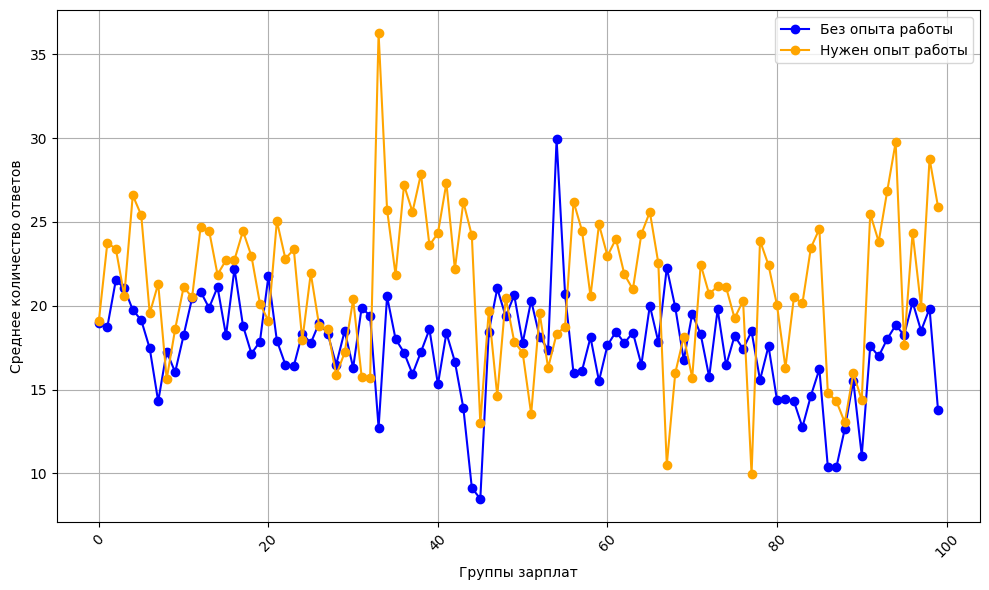

In [134]:
# Построение графиков
bacet=100
ft = len(data) // bacet
lst =  [data.iloc[i: i + ft] for i in range(0, len(data), ft)][:-1]
dt = []
dw = []
dtw = []
for t in lst:
    full_day_no_exp = t[t['work_schedule'] != 'tight']['response_count'].loc[t['length_of_employment']=='no_experience'].mean()
    full_day_exp = t[t['work_schedule'] != 'tight']['response_count'].loc[t['length_of_employment']!='no_experience'].mean()
    dt.append(full_day_no_exp)
    dw.append(full_day_exp)
    dtw.append((full_day_no_exp - full_day_exp) / full_day_no_exp)

plt.figure(figsize=(10, 6))
plt.plot( dt, marker='o', label='Без опыта работы', color='blue')
plt.plot( dw, marker='o', label='Нужен опыт работы', color='orange')

# plt.title('Среднее количество ответов по группам зарплат (на flexible)')
plt.xlabel('Группы зарплат')
plt.ylabel('Среднее количество ответов')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Выбросы

In [153]:
data_vbr = pd.read_csv('hh ru DATASET.csv')
data_vbr['work_schedule'] = data_vbr['work_schedule'].replace({'flexible': 'flexible&remote', 'remote': 'flexible&remote'})
data_vbr['work_schedule'] = data_vbr['work_schedule'].replace({'flyInFlyOut': 'tight', 'full_day': 'tight', 'shift': 'tight'})
labels = ['Ниже среднего', 'Выше среднего']
bins = [0, 57000, data_vbr['compensation_from'].max()]
data_vbr['salary_cat'] = pd.cut(data_vbr['compensation_from'], bins=bins, labels=labels)

In [154]:
s_group_1 = data_vbr[(data_vbr['work_schedule'] == 'flexible&remote') & (data_vbr['salary_cat'] == 'Ниже среднего')]
s_group_2 = data_vbr[(data_vbr['work_schedule'] != 'flexible&remote') & (data_vbr['salary_cat'] == 'Ниже среднего')]
s_group_3 = data_vbr[(data_vbr['work_schedule'] == 'flexible&remote') & (data_vbr['salary_cat'] == 'Ниже среднего')]
s_group_4 = data_vbr[(data_vbr['work_schedule'] == 'flexible&remote') & (data_vbr['salary_cat'] != 'Ниже среднего')]
s_group_5 = data_vbr[(data_vbr['work_schedule'] != 'flexible&remote') & (data_vbr['salary_cat'] != 'Ниже среднего')]
s_group_1['type'] = 'Свободный график и низкая зп'
s_group_2['type'] = 'Полная занятость и низкая зп'
s_group_3['type'] = 'Свободный график и низкая зп'
s_group_4['type'] = 'Свободный график и высокая зп'
s_group_5['type'] = 'Полная занятость и высокая зп'

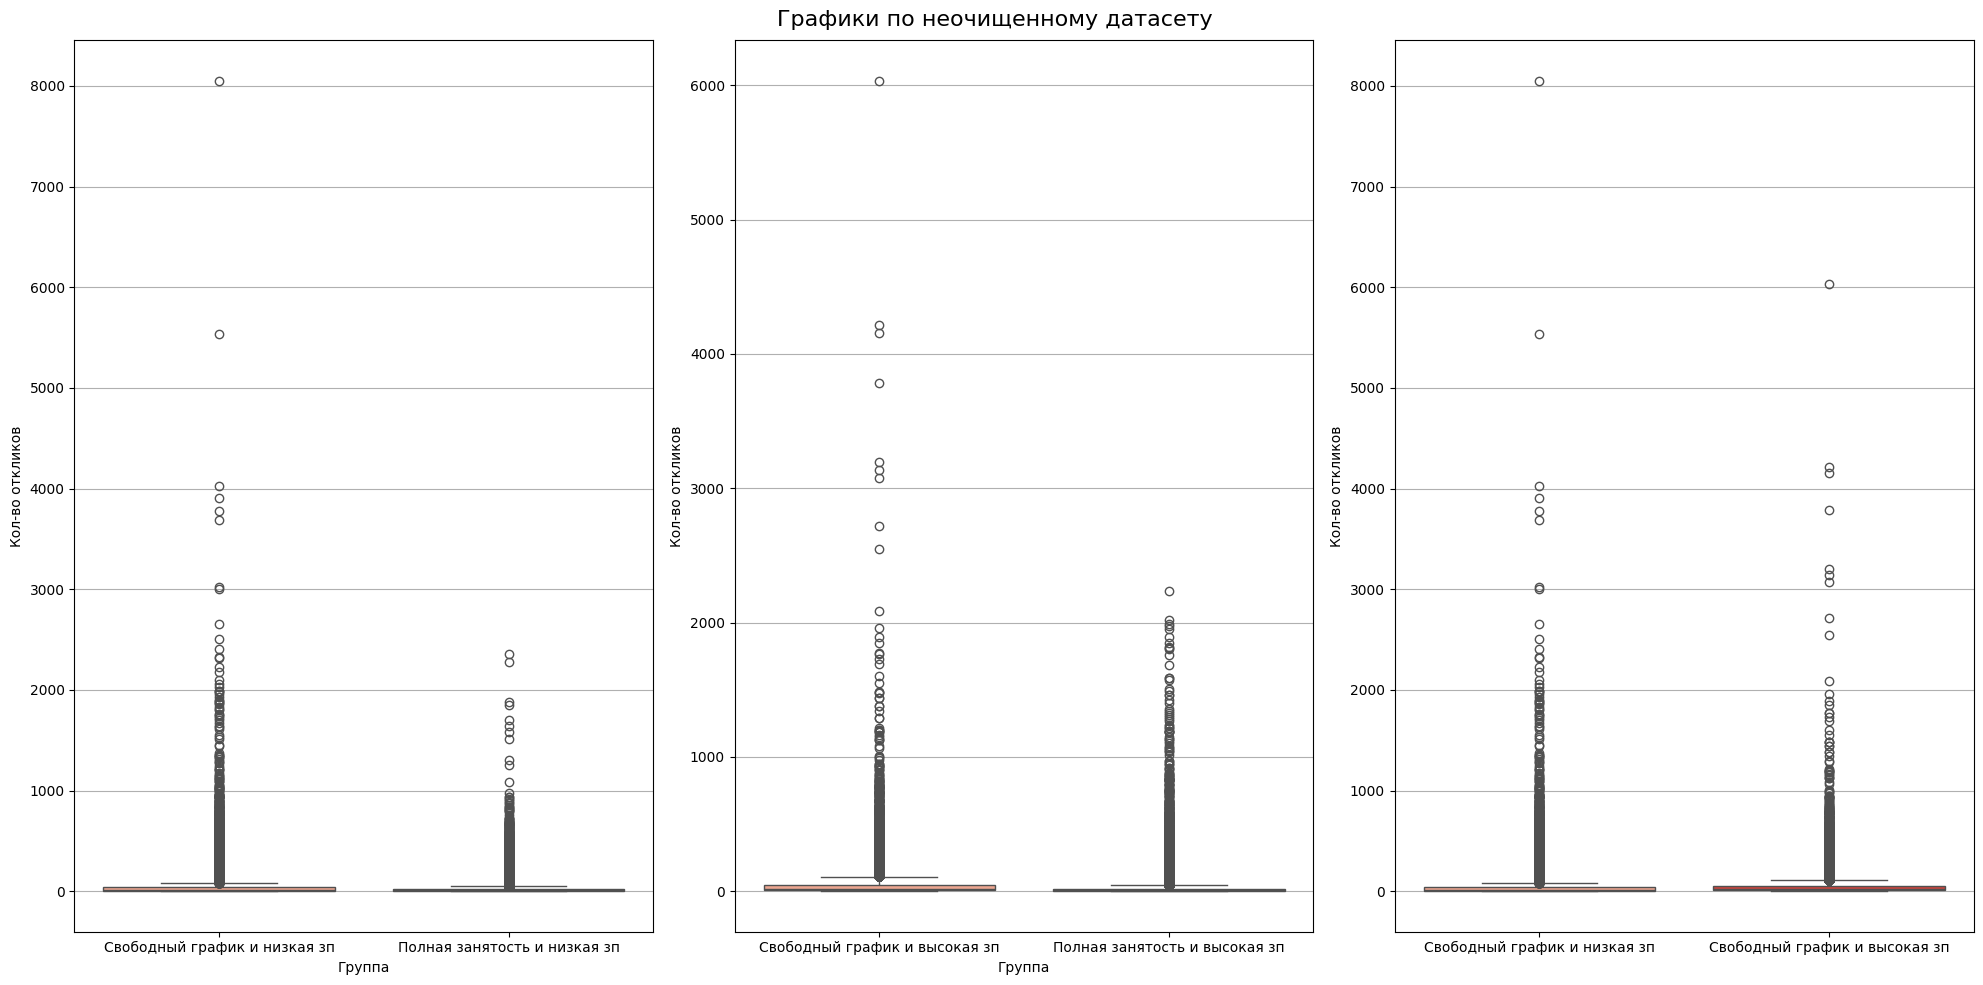

In [159]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Объединение данных и переименование столбцов
# combined_data = pd.concat([group_1, group_2]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'})

fig, axis = plt.subplots(1, 3, figsize=(20, 10))

# Построение графиков
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([s_group_1, s_group_2]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[0])
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([s_group_4, s_group_5]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[1])
sns.boxplot(x='Группа', y='Кол-во откликов', 
            data=pd.concat([s_group_3, s_group_4]).rename(columns={'type': 'Группа', 'response_count': 'Кол-во откликов'}), 
            palette='Reds', ax=axis[2])

# Установка ограничений по оси Y для всех графиков
for ax in axis:
    # ax.set_ylim(0, 80)  # Установка ограничений по оси Y
    ax.grid(axis='y')


# Заголовок и подписи
fig.suptitle('Графики по неочищенному датасету', fontsize=16)
plt.xlabel('')  # Подпись для оси X
plt.ylabel('Кол-во откликов')  # Подпись для оси Y

plt.tight_layout()
plt.show()

In [138]:
s_group_1['response_count'].mean(), s_group_2['response_count'].mean()

(18.690579884091765, 14.572774948313247)

In [139]:
test = ttest_ind(s_group_1['response_count'], s_group_2['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 38.56474408400285, p-value 0.0


In [140]:
s_group_4['response_count'].mean(), s_group_5['response_count'].mean()

(16.64324525493115, 13.650467971619786)

In [141]:
test = ttest_ind(s_group_4['response_count'], s_group_5['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 20.15223789120778, p-value 4.012276776783214e-90


In [142]:
s_group_3['response_count'].mean(), s_group_4['response_count'].mean()

(18.690579884091765, 16.64324525493115)

In [143]:
test = ttest_ind(s_group_3['response_count'], s_group_4['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 9.764409618849918, p-value 1.6898681197928248e-22


In [144]:
s_group_2['response_count'].mean(), s_group_5['response_count'].mean()

(14.572774948313247, 13.650467971619786)

In [145]:
test = ttest_ind(s_group_2['response_count'], s_group_5['response_count'])

print(f'metric {test.statistic}, p-value {test.pvalue}')

metric 13.622361110242993, p-value 3.042561102022763e-42
